In [1]:
from PIL import Image
import os
import time
import copy
import warnings
import random
import numpy as np
import pandas as pd
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
from torch.nn import functional as F
import torchvision
import torch.optim as optim
import torch.backends.cudnn as cudnn
from torch.utils.data import DataLoader, Dataset, sampler
from matplotlib import pyplot as plt
import torchvision.transforms as transforms
from albumentations import (HorizontalFlip,VerticalFlip, ShiftScaleRotate, Normalize, Resize, Compose, GaussNoise,RandomRotate90,Transpose,RandomBrightnessContrast,RandomCrop)
from albumentations.pytorch import ToTensor
import albumentations as albu
import matplotlib.image as mpi
from sklearn.metrics import f1_score
warnings.filterwarnings("ignore")
seed = 69
random.seed(seed)
os.environ["PYTHONHASHSEED"] = str(seed)
np.random.seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True

In [2]:
img = plt.imread('Train/10023.jpg')

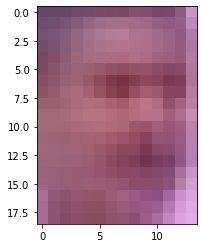

In [3]:
plt.imshow(img)

In [4]:
train_df = pd.read_csv('train.csv')

In [5]:
train_df.head()

,ID,Class
0,377.jpg,MIDDLE
1,17814.jpg,YOUNG
2,21283.jpg,MIDDLE
3,16496.jpg,YOUNG
4,4487.jpg,MIDDLE


In [6]:
df1 = train_df['Class']
df2 = train_df["ID"]
df1 = pd.get_dummies(df1)
df = pd.concat([df2,df1], axis=1)
df.head()

,ID,MIDDLE,OLD,YOUNG
0,377.jpg,1,0,0
1,17814.jpg,0,0,1
2,21283.jpg,1,0,0
3,16496.jpg,0,0,1
4,4487.jpg,1,0,0


In [7]:
classes = ['MIDDLE','OLD','YOUNG']
df.shape

(19906, 4)

In [8]:
size = df.shape[0]
for i in range(50):
    ind = random.randint(0,size)
    name = df.iloc[ind][0]
    path = 'Train/'+str(name)
    img = plt.imread(path)
    print(img.shape)

(92, 57, 3)
(57, 38, 3)
(81, 49, 3)
(86, 77, 3)
(166, 98, 3)
(41, 32, 3)
(41, 36, 3)
(39, 29, 3)
(84, 48, 3)
(156, 133, 3)
(134, 105, 3)
(155, 126, 3)
(343, 376, 3)
(145, 119, 3)
(39, 29, 3)
(86, 36, 3)
(49, 42, 3)
(166, 133, 3)
(23, 23, 3)
(89, 79, 3)
(39, 29, 3)
(57, 28, 3)
(55, 44, 3)
(78, 49, 3)
(163, 108, 3)
(246, 180, 3)
(71, 53, 3)
(43, 33, 3)
(45, 35, 3)
(156, 82, 3)
(172, 166, 3)
(264, 323, 3)
(242, 205, 3)
(41, 22, 3)
(304, 250, 3)
(194, 177, 3)
(135, 91, 3)
(52, 49, 3)
(32, 25, 3)
(54, 44, 3)
(106, 94, 3)
(65, 43, 3)
(79, 50, 3)
(68, 44, 3)
(54, 26, 3)
(67, 44, 3)
(318, 276, 3)
(54, 46, 3)
(93, 85, 3)
(96, 87, 3)


In [9]:
train_df,val_df = train_test_split(df,test_size=0.2)

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [11]:
class Age(Dataset):
    
    def __init__(self,df,phase):
        self.phase = phase
        self.df = df
        if phase == 'train':
            self.transforms = albu.Compose([
            albu.SmallestMaxSize(64),
            albu.RandomCrop(64,64),
            albu.Normalize((0.485, 0.456, 0.406),(0.229, 0.224, 0.225)),
            ToTensor()
            ])
        elif phase == 'val':
            self.transforms = albu.Compose([
                albu.Resize(64,64),
                albu.Normalize((0.485, 0.456, 0.406),(0.229, 0.224, 0.225)),
                ToTensor()
            ])
        elif phase == 'test':
            self.transforms = albu.Compose([
                albu.Resize(64,64),
                albu.Normalize((0.485, 0.456, 0.406),(0.229, 0.224, 0.225)),
                ToTensor()
            ])
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self,index):
        label = self.df.iloc[index,1:]
        label = label.to_numpy()
        label = np.argmax(label)
        name = self.df.iloc[index,0]
        if self.phase == 'train' or 'val':
            path = 'Train/' + str(name)
        if self.phase == 'test':
            path = 'Test/' + str(name)
        img = plt.imread(path)
        img = self.transforms(image = np.array(img))
        img = img['image']
        
        return img,label

In [12]:
traindata = Age(train_df,phase = 'train')
valdata = Age(val_df,phase = 'val')

In [13]:
trainloader = DataLoader(traindata,batch_size=16)
valloader = DataLoader(valdata,batch_size = 16)

In [14]:
dataiter = iter(trainloader)
img,label = dataiter.next()
img.shape

torch.Size([16, 3, 64, 64])

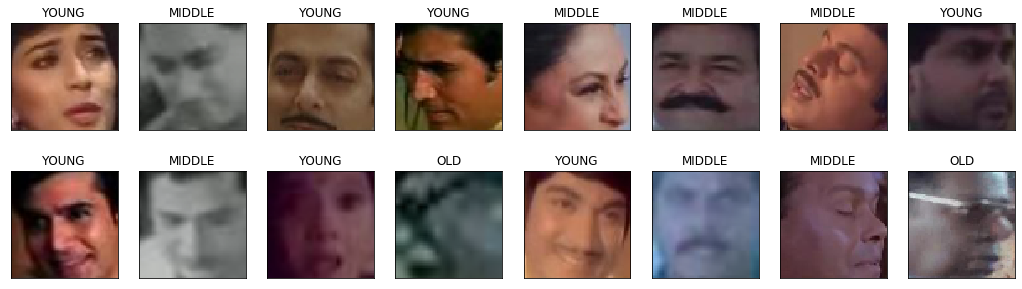

In [15]:
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
def im_show(img):
    npimg = img.numpy().transpose((1,2,0))*std + mean
    npimg = np.clip(npimg, 0., 1.)
    plt.imshow(npimg)
fig = plt.figure(figsize=(18,5))

for i in np.arange(16):
    ax = fig.add_subplot(2,8,i+1,xticks=[],yticks=[])
    im_show(img[i])
    ax.set_title(classes[label[i]])

In [16]:
class mymodel(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3,32,(3,3),padding=1)
        self.bn1 = nn.BatchNorm2d(num_features =32)
        self.conv2 = nn.Conv2d(32,64,(3,3),padding=1)
        self.bn2 = nn.BatchNorm2d(num_features = 64)
        self.pool1 = nn.MaxPool2d(kernel_size = (2,2),stride=(2,2))
        
        self.conv3 = nn.Conv2d(64,128,(3,3),padding=1)
        self.bn3 = nn.BatchNorm2d(num_features=128)
        self.conv4 = nn.Conv2d(128,256,(3,3),padding=1)
        self.bn4 = nn.BatchNorm2d(num_features = 256)
        self.pool2 = nn.MaxPool2d(kernel_size=(2,2) , stride = (2,2))
        
        self.linear1 = nn.Linear(256*16*16,512)
        self.bn5 = nn.BatchNorm1d(num_features = 512)
        self.linear2 = nn.Linear(512,256)
        self.bn6 = nn.BatchNorm1d(num_features = 256)
        self.linear3 = nn.Linear(256,3)
        
    def forward(self,x):
        x = self.bn1(self.conv1(x))
        x = F.relu(x)
        x = self.bn2(self.conv2(x))
        x = self.pool1(F.relu(x))
        
        x = self.bn3(self.conv3(x))
        x = F.relu(x)
        x = self.bn4(self.conv4(x))
        x = self.pool2(F.relu(x))
        
        x = x.reshape((-1,256*16*16))
        x = self.bn5(self.linear1(x))
        x = F.relu(x)
        x = self.bn6(self.linear2(x))
        x = F.relu(x)
        scores = F.softmax(self.linear3(x))
        return scores

In [17]:
y = mymodel()
x = torch.zeros((16,3,64,64))
x = y(x)
x.shape

torch.Size([16, 3])

In [18]:
resnet = mymodel()
from torch.optim import lr_scheduler
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(resnet.parameters(), lr=0.001, betas=(0.9, 0.999),weight_decay=0.001)
scheduler = ReduceLROnPlateau(optimizer,factor=0.33, mode="min", patience=4)

In [19]:
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

In [20]:
def train_model(dataloaders,model, criterion, optimizer, scheduler, num_epochs):
    since = time.time()
    dataset_sizes = {'train': len(dataloaders['train'].dataset), 
                     'val': len(dataloaders['val'].dataset)}
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    number_of_iter = 0
    acc_train = []
    acc_val = []
    loss_train = []
    loss_val = []
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  
            else:
                model.eval()   

            current_loss = 0.0
            current_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                optimizer.zero_grad()
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                current_loss += loss.item() * inputs.size(0)
                current_corrects += torch.sum(preds == labels.data)

            epoch_loss = current_loss / dataset_sizes[phase]
            epoch_acc = current_corrects.double() / dataset_sizes[phase]
            if phase=="train":
                acc_train.append(epoch_acc)
                loss_train.append(epoch_loss)
            else:
                acc_val.append(epoch_acc)
                loss_val.append(epoch_loss)
                scheduler.step(epoch_loss)
            
            
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))
            

            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                torch.save(model.state_dict(),'best_weights.pth')
                torch.save(optimizer.state_dict(), 'optimizer.pth')

        print('Current LR: {:.4f}'.format(get_lr(optimizer)))
        print()

    time_since = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_since // 60, time_since % 60))
    print('Best val Acc: {:4f}'.format(best_acc))
    model.load_state_dict(best_model_wts)
    
    
    return model,acc_val,acc_train,loss_train,loss_val


In [21]:
resnet = resnet.to(device)
dataloaders = {"train":trainloader,"val":valloader}
num_epochs= 40
start_time = time.time()
model,acc_val,acc_train,loss_train,loss_val = train_model(dataloaders, resnet, criterion, optimizer, scheduler, num_epochs=num_epochs)

Epoch 0/39
train Loss: 0.9431 Acc: 0.5946
val Loss: 0.9482 Acc: 0.5952
Current LR: 0.0010

Epoch 1/39
train Loss: 0.9310 Acc: 0.6076
val Loss: 0.9122 Acc: 0.6308
Current LR: 0.0010

Epoch 2/39
train Loss: 0.9234 Acc: 0.6158
val Loss: 0.9206 Acc: 0.6190
Current LR: 0.0010

Epoch 3/39
train Loss: 0.9105 Acc: 0.6334
val Loss: 0.8971 Acc: 0.6467
Current LR: 0.0010

Epoch 4/39
train Loss: 0.9026 Acc: 0.6393
val Loss: 0.8882 Acc: 0.6567
Current LR: 0.0010

Epoch 5/39
train Loss: 0.8980 Acc: 0.6442
val Loss: 0.8840 Acc: 0.6587
Current LR: 0.0010

Epoch 6/39
train Loss: 0.8942 Acc: 0.6477
val Loss: 0.8786 Acc: 0.6670
Current LR: 0.0010

Epoch 7/39
train Loss: 0.8937 Acc: 0.6488
val Loss: 0.8752 Acc: 0.6703
Current LR: 0.0010

Epoch 8/39
train Loss: 0.8895 Acc: 0.6539
val Loss: 0.8735 Acc: 0.6700
Current LR: 0.0010

Epoch 9/39
train Loss: 0.8878 Acc: 0.6558
val Loss: 0.8754 Acc: 0.6683
Current LR: 0.0010

Epoch 10/39
train Loss: 0.8850 Acc: 0.6584
val Loss: 0.8718 Acc: 0.6698
Current LR: 0.0010

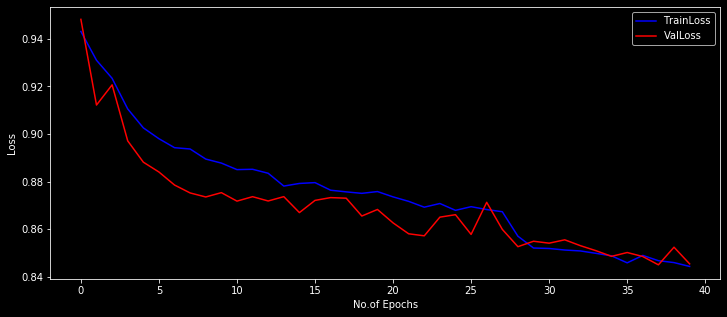

In [22]:
epoch = []
for x in range(num_epochs):
    epoch.append(x)
plt.style.use('dark_background')
fig = plt.figure(figsize = (12,5))
plt.plot(epoch,loss_train,label = 'TrainLoss',color = 'blue')
plt.plot(epoch,loss_val,label = 'ValLoss',color = 'red')
plt.xlabel('No.of Epochs')
plt.ylabel('Loss')
plt.legend()

In [23]:
sample = pd.read_csv('sample_submission.csv')

In [24]:
sample.head()

,Class,ID
0,MIDDLE,25321.jpg
1,MIDDLE,989.jpg
2,MIDDLE,19277.jpg
3,MIDDLE,13093.jpg
4,MIDDLE,5367.jpg


In [25]:
output = pd.DataFrame(index = sample.index,columns = sample.keys())
output['ID'] = sample['ID']

In [26]:
output.head()

,Class,ID
0,NaN,25321.jpg
1,NaN,989.jpg
2,NaN,19277.jpg
3,NaN,13093.jpg
4,NaN,5367.jpg


In [27]:
sample = sample[["ID","Class"]]
sample.head()

,ID,Class
0,25321.jpg,MIDDLE
1,989.jpg,MIDDLE
2,19277.jpg,MIDDLE
3,13093.jpg,MIDDLE
4,5367.jpg,MIDDLE


In [28]:
testdata = Age(sample,phase = 'test')

In [29]:
testloader = DataLoader(testdata,batch_size = 16)

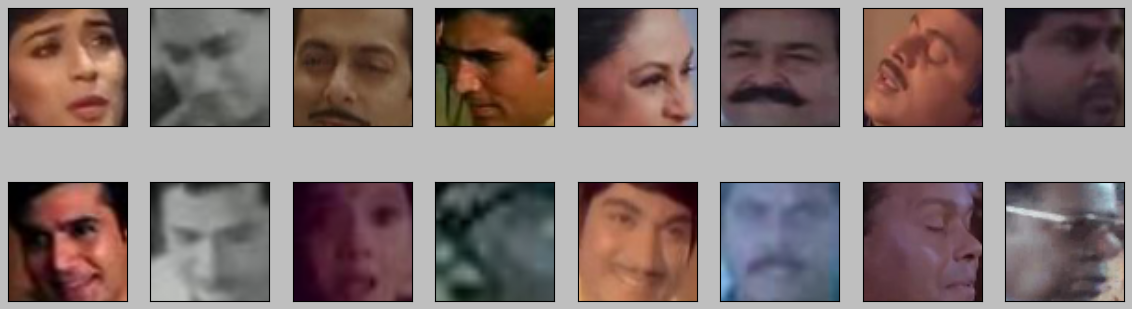

In [30]:
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
def im_show(img):
    npimg = img.numpy().transpose((1,2,0))*std + mean
    npimg = np.clip(npimg, 0., 1.)
    plt.imshow(npimg)
plt.style.use('classic')
fig = plt.figure(figsize=(18,5))
for i in np.arange(16):
    ax = fig.add_subplot(2,8,i+1,xticks=[],yticks=[])
    im_show(img[i])

In [31]:
def test_submission(model):
    since = time.time()
    sub_output = []
    model.train(False)
    for data in testloader:
        inputs,labels = data
        inputs = inputs.to(device)
        outputs = model(inputs)
        _,pred = torch.max(outputs.data,1)
        pred = pred.data.cpu().numpy()
        sub_output.append(pred.data)
    sub_output = np.concatenate(sub_output)
    output['Class'] = sub_output
    print()
    time_elapsed = time.time() - since
    print('Run complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))

In [32]:
test_submission(model)


Run complete in 0m 13s


In [33]:
output.head()

,Class,ID
0,0,25321.jpg
1,2,989.jpg
2,2,19277.jpg
3,2,13093.jpg
4,0,5367.jpg


In [34]:
d = {0:'MIDDLE',1:'OLD',2:'YOUNG'}
output['Class'] = output['Class'].map(d)
output.head()

,Class,ID
0,MIDDLE,25321.jpg
1,YOUNG,989.jpg
2,YOUNG,19277.jpg
3,YOUNG,13093.jpg
4,MIDDLE,5367.jpg


In [35]:
output.to_csv('40epochmymodel.csv',index=False)